# Fitting a model to data with both x and y errors with `PyStan`

### In the previous fitting a line tutorial, we fit a line to data with x and y errors and showed how marginalization can help get around the problem of needing to know 'true x'. This is doable for a simple model such as a straight line but not for much else. Another approach is to sample over each x, this is a high dimensional problem. So we can use PyStan and HMC which copes well in these scenario's

In [91]:
%pylab inline
import stan_utils as stan

Populating the interactive namespace from numpy and matplotlib


/Users/nsarin/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['cov']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### First we create the data and plot it

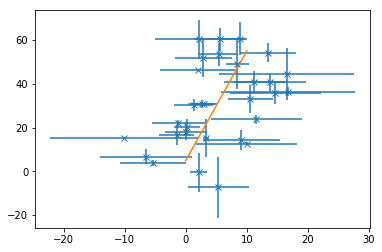

In [102]:
#define our model, a line
def function(x, m, c, **kwargs):
    y = m*x + c
    return y

#make a function to create and plot our data
def make_data(points, m , c, xerr, yerr, seed):
    np.random.seed(seed)
    xtrue = np.linspace(0,10,points)
    ytrue = function(x = xtrue, m = m, c = c)

    xerr = xerr * np.random.randn(points)
    yerr = yerr * np.random.randn(points)
    noise = np.random.normal(0,1,points)
    xobs = xtrue + xerr
    yobs = ytrue + yerr
    
    plt.errorbar(xobs, yobs, xerr = xerr, yerr = yerr, fmt = 'x')
    plt.plot(xtrue, ytrue)
    plt.show()
    
    #return 
    data = {'xtrue': xtrue, 'ytrue':ytrue, 'xobs':xobs, 'yobs':yobs, 'xerr':np.sqrt(abs(xerr)), 'yerr':np.sqrt(abs(yerr))}
    
    return data

data = make_data(points = 30, m = 5, c = 5, xerr = 5, yerr = 5, seed = 123)

In [93]:
model = stan.load_stan_model("line.stan")

INFO:root:Using pre-compiled model from line.stan.cached


In [94]:
data_dict = dict(x=data['xobs'], y=data['yobs'], x_err=data['xerr'], y_err=data['yerr'], N=data['xobs'].size)

DM = np.vstack((np.ones_like(data['xobs']), data['xobs'])).T
C = np.diag(data['yerr']**2)
cov = np.linalg.inv(DM.T @ np.linalg.solve(C, DM))
c, m = cov @ (DM.T @ np.linalg.solve(C, data['yobs']))

init_dict = dict(c=c, m=m, x_t=data['xobs'])

In [95]:
# Optimize
p_opt = model.optimizing(data=data_dict, init=init_dict, iter=1000)

In [96]:
# Sample
samples = model.sampling(**stan.sampling_kwds(
    data=data_dict, chains=2, init=p_opt, iter=50000))

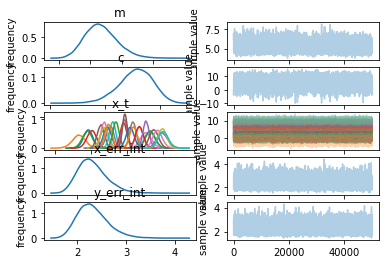

In [97]:
fig = samples.traceplot()
fig.savefig("trace.png")

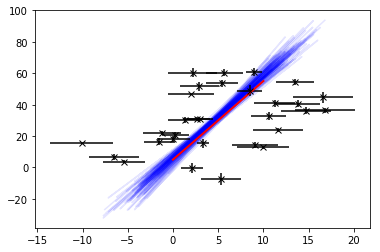

In [98]:
plt.errorbar(data['xobs'], data['yobs'], xerr = data['xerr'], yerr = data['yerr'], fmt = 'x', color = 'black')

s = samples.extract(["c", "m", "x_t", "x_err_int"])
c_s, m_s, xt_s, x_err_int = s["c"], s["m"], s["x_t"], s["x_err_int"]


idx = np.random.choice(c_s.size, 100, replace=False)
for i in idx:

    xi = np.random.normal(xt_s[i], x_err_int[i])

    plt.plot(xi, c_s[i] + m_s[i] * xi, c="blue", zorder=-1, alpha=0.1)

plt.plot(data['xtrue'], data['ytrue'], c="r", lw=2)

fig.savefig("fit.png")



In [99]:
m_l, m, m_u = np.percentile(m_s, [16, 50, 84])
m_err_neg, m_err_pos = (m_l - m, m_u - m)

c_l, c, c_u = np.percentile(c_s, [16, 50, 84])
c_err_neg, c_err_pos = (c_l - c, c_u - c)

print(f"m = {m:.2f} ({m_err_pos:+.2f}, {m_err_neg:+.2f})")
print(f"c = {c:.2f} ({c_err_pos:+.2f}, {c_err_neg:+.2f})")

m = 5.31 (+0.54, -0.46)
c = 5.73 (+2.85, -3.22)


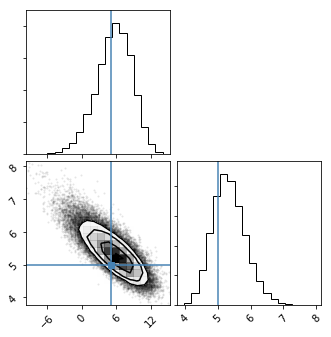

In [100]:
import corner
Z = np.vstack([c_s, m_s]).T
fig = corner.corner(Z, truths=[5, 5])